In [76]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import environment
import td
from constants import BOOTSTRAP_SARSA, BOOTSTRAP_EXPECTED, BOOTSTRAP_Q

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
def to_arrow(pi):
    directions = []
    arrows = ["↑", "→", "↓", "←"]
    for actions in pi:
        for i in range(len(actions)):
            if actions[i] > 0:
                directions.append(arrows[i])
    
    return directions

def run(grid, agent, n_runs=25):
    grid_actions = 4
    # env
    env = environment.create(grid=grid, step_reward=-1, cliff_reward=-100)

    # S, A
    n_row = len(grid)
    n_col = len(grid[0])
    S = [s for s in range(n_row * n_col)]
    A = [a for a in range(grid_actions)]
    
    bootstraps = [BOOTSTRAP_SARSA, BOOTSTRAP_EXPECTED, BOOTSTRAP_Q]
    results = []
    
    for bootstrap in bootstraps:
        agent["bootstrap"] = bootstrap
        error_histories = []
        length_histories = []
        visit_counts = []
        q, pi = None, None
        
        for i in tqdm(range(n_runs)):
            q, pi, log = td.learn(S, A, env, agent)
            error_history, length_history, visit_count = log
            
            error_histories.append(error_history)
            length_histories.append(length_history)
            visit_counts.append(visit_count)
        
        results.append((bootstrap, np.average(error_histories, axis=0), 
                        np.average(length_histories, axis=0), np.average(visit_counts, axis=0)))
    
    return results

plt.rcParams['figure.figsize'] = [10, 5]

def plot(title, data):
    for d in data:
        plt.plot(d[1], label=d[0])
    plt.title(title)
    plt.legend()
    plt.show()
    
def print_visit_count(data, n_row, n_col):
    print("visit count last 20 episodes")
    for d in data:
        print(d[0])
        print(d[1].reshape(n_row, n_col))


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


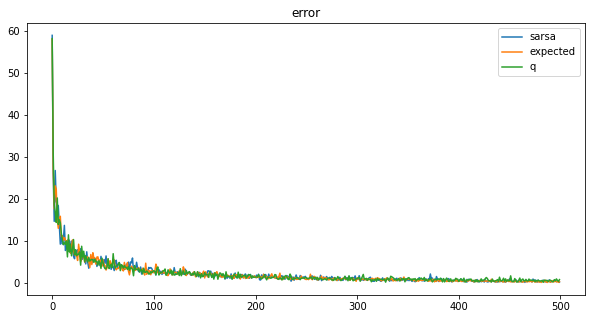

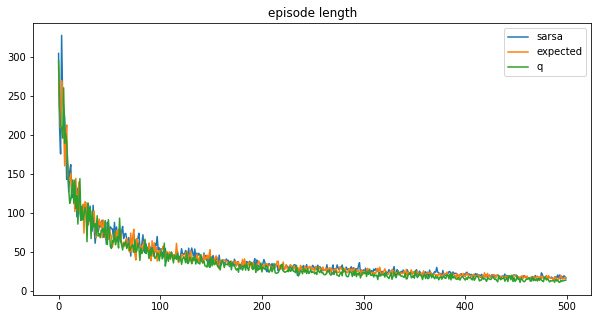

visit count last 20 episodes
sarsa
[[ 4.32  4.56  4.6   3.76  3.    2.4   1.8 ]
 [ 5.4   4.6   4.16  3.8   3.28  2.56  1.88]
 [ 7.88  5.88  4.84  4.32  3.72  3.08  2.92]
 [19.32 16.68 15.68 15.84 14.84 15.04 17.24]
 [22.72  5.84  2.96  2.6   2.32  3.   19.36]
 [22.92  0.    0.    0.    0.    0.   19.  ]
 [12.68  3.4   1.92  3.16  2.8   1.    0.92]]
expected
[[ 4.4   4.92  4.48  3.76  3.32  2.64  2.16]
 [ 5.76  5.2   4.16  3.76  3.28  2.56  1.92]
 [ 8.24  6.28  4.6   4.32  3.64  3.52  3.16]
 [19.96 14.8  13.6  13.84 14.08 14.76 17.4 ]
 [21.4   3.16  2.08  1.84  1.52  1.88 18.56]
 [21.24  0.    0.    0.    0.    0.   19.  ]
 [ 7.28  3.36  2.88  2.68  2.2   1.72  1.76]]
q
[[ 1.76  1.76  1.52  1.16  0.6   0.4   0.52]
 [ 2.2   2.04  2.04  1.76  0.96  0.6   0.64]
 [ 2.84  2.36  2.12  1.76  1.2   0.8   0.52]
 [ 4.8   3.24  2.84  2.28  2.2   1.8   1.52]
 [14.08 10.28 10.04  9.68 10.08 10.52 11.4 ]
 [24.32  0.    0.    0.    0.    0.   19.  ]
 [12.04 11.28 10.96 10.84 10.36  9.72  9.36]]


In [78]:
# online learning without background planning
grid = [
    ".......",
    ".......",
    ".......",
    ".......",
    ".......",
    "SCCCCCT",
    "......."
]
n_row = len(grid)
n_col = len(grid[0])

# agent
agent = {
    "discount": 0.9,
    "step_size": 0.05,
    "epsilon": 0.1,
    "trace_length": 3,
    "n_iterations": 500,
    "learn_online": True,
    "plan_background": False
}

results = run(grid, agent, 25)

plot("error", [(result[0], result[1]) for result in results])
plot("episode length", [(result[0], result[2]) for result in results])
print_visit_count([(result[0], result[3]) for result in results], n_row, n_col)


100%|██████████| 25/25 [00:08<00:00,  3.11it/s]


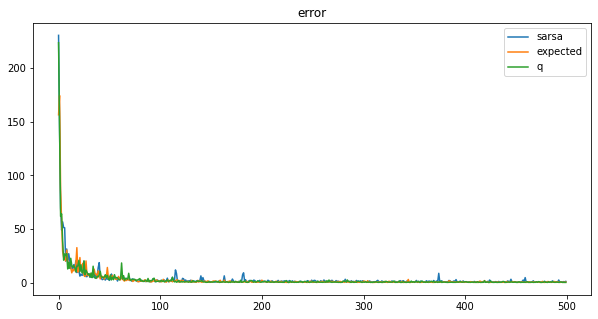

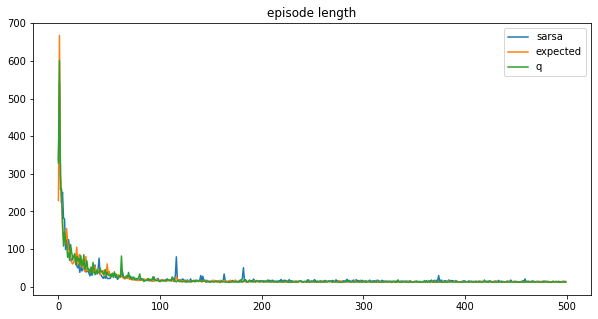

visit count last 20 episodes
sarsa
[[ 0.    0.04  0.16  0.08  0.12  0.24  0.16]
 [ 0.24  0.6   0.68  0.76  0.64  0.88  0.68]
 [ 9.36 11.24 11.52 11.2  10.64  8.76  6.16]
 [20.2  11.84 10.2  10.64 12.6  14.44 19.72]
 [20.64  0.76  0.4   0.64  0.72  0.88 20.  ]
 [20.72  0.    0.    0.    0.    0.   19.  ]
 [ 1.    0.12  0.72  0.12  0.12  0.08  0.12]]
expected
[[ 1.28  0.08  0.4   0.6   0.2   0.16  0.12]
 [ 2.24  0.36  0.08  0.04  0.24  0.2   0.2 ]
 [ 0.92  0.88  1.04  1.12  1.72  1.4   1.8 ]
 [20.   20.36 20.16 19.76 19.44 19.28 20.04]
 [20.72  1.6   1.    1.2   0.96  2.08 20.52]
 [21.08  0.    0.    0.    0.    0.   19.  ]
 [ 0.48  0.04  0.04  0.04  0.04  0.16  0.16]]
q
[[ 0.88  0.32  0.36  0.04  0.08  0.    0.  ]
 [ 0.4   0.28  0.32  0.2   0.12  0.04  0.04]
 [ 0.56  0.88  1.    1.    1.08  0.92  1.16]
 [20.08 20.52 20.04 20.28 20.56 19.88 20.48]
 [20.48  1.52  1.04  1.    1.    0.88 20.28]
 [21.    0.    0.    0.    0.    0.   19.  ]
 [ 2.8   1.04  0.12  0.08  0.04  0.2   0.2 ]]


In [79]:
# online learning with background planning
agent["plan_background"] = True
agent["trace_length"] = 3

results = run(grid, agent, 25)

plot("error", [(result[0], result[1]) for result in results])
plot("episode length", [(result[0], result[2]) for result in results])
print_visit_count([(result[0], result[3]) for result in results], n_row, n_col)
